In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs
#
from copy import deepcopy as cp

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [4]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'

Figures will be saved in: /home/561/erd561/figures/SAMexp/t09_Ekman_transport



In [5]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:41482' processes=4 cores=8>
CPU times: user 753 ms, sys: 177 ms, total: 930 ms
Wall time: 7.21 s


In [6]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

nyf_years = np.arange(477, 487)
ctrl_years = np.arange(566, 576)
# hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(611, 621)

nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
# hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(1-nyf_years_len, 0), 
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len+1 + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

for y in nyf_years:
    path1.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
    path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20]
30
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/

In [7]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        SST = \
            xr.open_dataset(p1, decode_times=False).\
            temp.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            drop(('geolon_t', 'geolat_t')).\
            mean(dim='time')
        
        tau_x = \
            xr.open_dataset(p2, decode_times=False).\
            tau_x.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))
        
        sea_level = \
            xr.open_dataset(p2, decode_times=False).\
            sea_level.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            mean(dim='time').\
            drop(('geolon_t', 'geolat_t'))*100
        
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                drop(('geolon_t', 'geolat_t')).\
                mean(dim='time')
            ], 'year'
            )
        
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))
            ], 'year'
            )
        
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p2, decode_times=False).\
                sea_level.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').\
                drop(('geolon_t', 'geolat_t'))*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
        
    else:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')
            ], 'year'
            )
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p2, decode_times=False).\
                sea_level.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')*100
            ], 'year'
            )
        print(str(p1) + ' OK')
print(SST)

xt_ocean = SST.xt_ocean
xt_ocean_corrected = xt_ocean + 360
SST = SST.assign_coords(xt_ocean=xt_ocean_corrected)
xu_ocean = tau_x.xu_ocean
xu_ocean_corrected = xu_ocean + 360
tau_x = tau_x.assign_coords(xu_ocean=xu_ocean_corrected)
sea_level = sea_level.assign_coords(xt_ocean=xt_ocean_corrected)

SST = SST.assign_coords(year=years)
tau_x = tau_x.assign_coords(year=years)
sea_level = sea_level.assign_coords(year=years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ocean.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output570/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output571/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output572/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output573/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output574/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output575/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output611/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output612/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output613/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output614/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output615/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output616/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output617/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output618/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output619/ocean_month.nc OK


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output620/ocean_month.nc OK
<xarray.DataArray 'temp' (year: 30, yt_ocean: 220, xt_ocean: 280)>
array([[[-0.401731, -0.380208, ...,  2.608085,  2.577984],
        [-0.406891, -0.376817, ...,  2.718419,  2.699332],
        ...,
        [23.918919, 23.935635, ..., 25.873558, 25.851952],
        [24.118069, 24.150646, ..., 26.02486 , 25.955761]],

       [[-0.469344, -0.446292, ...,  2.588118,  2.527822],
        [-0.461044, -0.434482, ...,  2.785284,  2.702575],
        ...,
        [23.966635, 23.966448, ..., 25.850706, 25.82425 ],
        [24.18553 , 24.199455, ..., 25.92586 , 25.899218]],

       ...,

       [[-0.440748, -0.452596, ...,  3.481239,  3.464719],
        [-0.406318, -0.394741, ...,  3.53492 ,  3.514677],
        ...,
        [24.305384, 24.327362, ..., 26.453362, 26.462786],
        [24.34794 , 24.386576, ..., 26.552256, 26.523329]],

       [[-0.584847, -0.561112, ...,  3.521433,  3.537624],
        [-0.536606, -0.498623

In [8]:
%%time

lon = [100-360, 170-360]
lat = [-60, -10]

for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        u = \
            xr.open_dataset(p2, decode_times=False).\
            u.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=slice(0,30)).\
            mean(dim='st_ocean').\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))*100
        
        v = \
            xr.open_dataset(p2, decode_times=False).\
            v.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=slice(0,30)).\
            mean(dim='st_ocean').\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))*100
        
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        u = \
            xr.concat([
                u,
                xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=slice(0,30)).\
                mean(dim='st_ocean').\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))*100
            ], 'year'
            )
        
        v = \
            xr.concat([
                v,
                xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=slice(0,30)).\
                mean(dim='st_ocean').\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
        
    else:
        u = \
            xr.concat([
                u,
                xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=slice(0,30)).\
                mean(dim='st_ocean').\
                mean(dim='time')*100
            ], 'year'
            )
        
        v = \
            xr.concat([
                v,
                xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=slice(0,30)).\
                mean(dim='st_ocean').\
                mean(dim='time')*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
print(u)
print(v)

u = u.assign_coords(xu_ocean=xu_ocean_corrected)
v = v.assign_coords(xu_ocean=xu_ocean_corrected)

u = u.assign_coords(year=years)
v = v.assign_coords(year=years)

/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ocean.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc O

In [9]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1[10:], path2[10:]):
    if p1 == path1[10]:
        net_sfc_heating = \
            xr.open_dataset(p2, decode_times=False).\
            net_sfc_heating.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            mean(dim='time')
        
        tau_curl = \
            xr.open_dataset(p2, decode_times=False).\
            tau_curl.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            mean(dim='time')
        
        print(str(p1) + ' OK')
        
    else:
        net_sfc_heating = \
            xr.concat([
                net_sfc_heating,
                xr.open_dataset(p2, decode_times=False).\
                net_sfc_heating.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        
        tau_curl = \
            xr.concat([
                tau_curl,
                xr.open_dataset(p2, decode_times=False).\
                tau_curl.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        
        print(str(p1) + ' OK')
print(net_sfc_heating)
print(tau_curl)

net_sfc_heating = net_sfc_heating.assign_coords(xt_ocean=xt_ocean_corrected)
tau_curl = tau_curl.assign_coords(xt_ocean=xt_ocean_corrected)

net_sfc_heating = net_sfc_heating.assign_coords(year=years[10:])
tau_curl = tau_curl.assign_coords(year=years[10:])

/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output570/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output571/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output572/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output573/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output574/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output575/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output611/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/output612/ocean_month.nc OK
/g/data/e14/

In [10]:
SST_nyf = SST.sel(year=slice(-9,0)).mean(dim='year')
SST_hist5069 = SST.sel(year=slice(1,10)).mean(dim='year')
SST_rcp85 = SST.sel(year=slice(11,20)).mean(dim='year')

tau_x_nyf = tau_x.sel(year=slice(-9,0)).mean(dim='year')
tau_x_hist5069 = tau_x.sel(year=slice(1,10)).mean(dim='year')
tau_x_rcp85 = tau_x.sel(year=slice(11,20)).mean(dim='year')

sea_level_nyf = sea_level.sel(year=slice(-9,0)).mean(dim='year')
sea_level_hist5069 = sea_level.sel(year=slice(1,10)).mean(dim='year')
sea_level_rcp85 = sea_level.sel(year=slice(11,20)).mean(dim='year')

u_nyf = u.sel(year=slice(-9,0)).mean(dim='year')
u_hist5069 = u.sel(year=slice(1,10)).mean(dim='year')
u_rcp85 = u.sel(year=slice(11,20)).mean(dim='year')

v_nyf = v.sel(year=slice(-9,0)).mean(dim='year')
v_hist5069 = v.sel(year=slice(1,10)).mean(dim='year')
v_rcp85 = v.sel(year=slice(11,20)).mean(dim='year')

net_sfc_heating_hist5069 = net_sfc_heating.sel(year=slice(1,10)).mean(dim='year')
net_sfc_heating_rcp85 = net_sfc_heating.sel(year=slice(11,20)).mean(dim='year')

tau_curl_hist5069 = tau_curl.sel(year=slice(1,10)).mean(dim='year')
tau_curl_rcp85 = tau_curl.sel(year=slice(11,20)).mean(dim='year')

h_ek = 30
rho_0 = 1027
omega = 7.2921*10**-5
lat = tau_x_hist5069.xu_ocean
f = 2 * omega * np.sin(lat * np.pi / 180)
f = np.expand_dims(f, axis=0)
V_ek_hist5069 = tau_x_hist5069 / f / rho_0
V_ek_rcp85 = tau_x_rcp85 / f / rho_0

Bbox(x0=0.125, y0=0.7721428571428571, x1=0.47727272727272724, y1=0.88)
[0.125, 0.7721428571428571, 0.43727272727272726, 0.88]
Bbox(x0=0.5477272727272726, y0=0.7721428571428571, x1=0.8999999999999999, y1=0.88)
[0.5477272727272726, 0.7721428571428571, 0.8599999999999999, 0.88]
Bbox(x0=0.125, y0=0.6427142857142857, x1=0.47727272727272724, y1=0.7505714285714286)
[0.125, 0.6427142857142857, 0.43727272727272726, 0.7505714285714286]
Bbox(x0=0.5477272727272726, y0=0.6427142857142857, x1=0.8999999999999999, y1=0.7505714285714286)
[0.5477272727272726, 0.6427142857142857, 0.8599999999999999, 0.7505714285714286]
Bbox(x0=0.125, y0=0.5132857142857142, x1=0.47727272727272724, y1=0.6211428571428571)
[0.125, 0.5132857142857142, 0.43727272727272726, 0.6211428571428571]


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth', 'color'
  s)


Bbox(x0=0.5477272727272726, y0=0.5132857142857142, x1=0.8999999999999999, y1=0.6211428571428571)
[0.5477272727272726, 0.5132857142857142, 0.8599999999999999, 0.6211428571428571]
Bbox(x0=0.125, y0=0.25442857142857134, x1=0.47727272727272724, y1=0.49171428571428566)
[0.125, 0.27942857142857136, 0.43727272727272726, 0.46671428571428564]
Bbox(x0=0.125, y0=0.12499999999999989, x1=0.8999999999999999, y1=0.23285714285714276)
[0.125, 0.12499999999999989, 0.8599999999999999, 0.23285714285714276]
Bbox(x0=0.5477272727272726, y0=0.25442857142857134, x1=0.8999999999999999, y1=0.49171428571428566)
[0.5477272727272726, 0.27942857142857136, 0.8599999999999999, 0.46671428571428564]
(28,)
(70,)
(70, 28)
(70, 28)
(70, 28)
(70, 28)
(70, 28)
[[ -4.6148734   -2.5994053   -0.2420994  ...  -0.4886937   -0.42565036
   -0.29632866]
 [ -3.3116844   -4.3667054   -2.4545193  ...   0.21167576   0.32637644
    0.40910113]
 [ -3.2015882   -4.1835723   -3.475122   ...   1.0465735    1.1166886
    1.021739  ]
 ...
 [  

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  s)


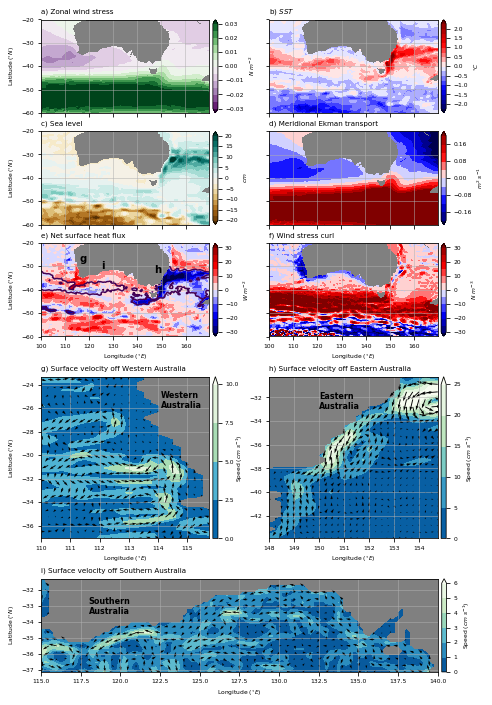

In [55]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
def bbox(pos):
    return matplotlib.transforms.Bbox(np.array([[pos[0],pos[1]],[pos[2],pos[3]]]))

fig = plt.figure() 
fig.set_size_inches(7.5,12)
matplotlib.rcParams.update({'font.size': 6}) 
col = 2
row = 6

ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.04, pos.y1] 
print(pos_plot)

cont_lev = arange(-0.03,0.03,0.005)
anom = tau_x_rcp85 - tau_x_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PRGn, extend='both')
ax.set_position(bbox(pos_plot))

plt.grid(linewidth=0.5)
plt.title(r'a) Zonal wind stress', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')
plt.ylabel('Latitude ($^{\circ}N$)')

axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$N\ m^{-2}$', cax=axins)


ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.04, pos.y1] 
print(pos_plot)

cont_lev = arange(-2.25,2.25,0.25)
anom = SST_rcp85 - SST_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both',)
ax.set_position(bbox(pos_plot))
plt.title('')
plt.grid(linewidth=0.5)
plt.title('b) $SST$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$^{\circ}C$', cax=axins)


ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.04, pos.y1] 
print(pos_plot)

cont_lev = arange(-20,20,2.5)
anom = sea_level_rcp85 - sea_level_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.BrBG, extend='both')
ax.set_position(bbox(pos_plot))
plt.title('')
plt.grid(linewidth=0.5)
plt.title(r'c) Sea level', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
ax.set_facecolor('gray')
plt.ylabel('Latitude ($^{\circ}N$)')
axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$cm$', cax=axins)

ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.04, pos.y1] 
print(pos_plot)

cont_lev = arange(-0.2,0.2,0.04)
anom = V_ek_rcp85 - V_ek_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
ax.set_position(bbox(pos_plot))
plt.title('')
plt.grid(linewidth=0.5)
plt.title(r'd) Meridional Ekman transport', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_xticks(arange(100,160,10))
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$m^{2}\ s^{-1}$', cax=axins)


ax = plt.subplot2grid((row, col), (2, 0), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.04, pos.y1] 
print(pos_plot)

cont_lev = arange(-30,30,5)
anom = net_sfc_heating_rcp85 - net_sfc_heating_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.contour(SST_rcp85.xt_ocean, SST_rcp85.yt_ocean, SST_rcp85 - SST_hist5069, 
            levels=[0.25], linewidth=1, color='k')

plt.text(116, -28, 'g', fontweight='bold', fontsize=10)
plt.text(147, -33, 'h', fontweight='bold', fontsize=10)
plt.text(125, -31, 'i', fontweight='bold', fontsize=10)

ax.set_position(bbox(pos_plot))
plt.title('')
plt.grid(linewidth=0.5)
plt.title(r'e) Net surface heat flux', loc='left')
plt.ylabel('Latitude ($^{\circ}N$)')
ax.set_facecolor('gray')
plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels('')
# plt.gca().set_yticklabels('')
plt.xlabel('Longitude ($^{\circ}E$)')
axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$W\ m^{-2}$', cax=axins)

ax = plt.subplot2grid((row, col), (2, 1), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.04, pos.y1] 
print(pos_plot)

cont_lev = arange(-0.00000005,0.00000005,0.00000001)
anom = tau_curl_rcp85 - tau_curl_hist5069
contf2 = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
ax.set_position(bbox(pos_plot))
plt.title('')
plt.grid(linewidth=0.5)
plt.title(r'f) Wind stress curl', loc='left')
plt.ylabel('')
plt.gca().set_xticks(arange(100,160,10))
# plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')
plt.xlabel('Longitude ($^{\circ}E$)')
axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'$N\ m^{-3}$', cax=axins)



ax = plt.subplot2grid((row, col), (3, 0), rowspan=2, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.025, pos.x1-0.04, pos.y1-0.025] 
print(pos_plot)

cont_lev = arange(0, 10, 2.5)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [110, 116]
Y_LIM = [-37, -23]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
# contf = plt.contourf(X, Y, V, add_colorbar=False, levels=cont_lev, cmap=plt.cm.coolwarm, extend='both')
# plt.title('')
n = 1

cmapQ = plt.cm.GnBu_r

speed = np.sqrt(U**2 + V**2)
U1 = cp(U)
V1 = cp(V)
U2 = U / speed
V2 = V / speed
tol = 0
U2 = U1 / (U1**2 + V1**2)**(1/4)
V2 = V1 / (U1**2 + V1**2)**(1/4)
speed2 = cp(speed)
# speed2[speed < tol] = np.NaN

contf = plt.contourf(X, Y, speed, add_colorbar=False, levels=cont_lev, cmap=cmapQ, extend='max')
plt.title('')
plt.text(114.1, -26, 'Western\nAustralia', fontweight='bold', fontsize=8)

vmin=tol
vmax=5
step=5
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# print(X.shape)
# print(Y.shape)
# print(U1.shape)
# print(V1.shape)
# print(U2.shape)
# print(V2.shape)
# print(speed.shape)

# Q1 = plt.quiver(X[0:188:n], 
#                 Y[0:132:n], 
#                 U1[0:132:n, 0:188:n], 
#                 V1[0:132:n, 0:188:n],
#                 width=0.0015, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 facecolor='w', edgecolor='k', linewidth=0.2)

Q2 = plt.quiver(X[0:188:n], 
                Y[0:132:n+2], 
                U2[0:132:n+2, 0:188:n], 
                V2[0:132:n+2, 0:188:n],
                cmap=cmap, norm=norm,
                width=0.005, scale=50,
                edgecolor='k', linewidth=0)
ax.set_position(bbox(pos_plot))

plt.grid(linewidth=0.5)
plt.title('g) Surface velocity off Western Australia', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.ylabel('Latitude ($^{\circ}N$)')
axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical', cax=axins)
cbar.set_label(label=r'Speed ($cm\ s^{-1}$)', labelpad=-4)


ax = plt.subplot2grid((row, col), (5, 0), rowspan=1, colspan=3)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.04, pos.y1] 
print(pos_plot)

cont_lev = arange(0, 6, 1)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [115, 140]
Y_LIM = [-37, -31]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
# contf = plt.contourf(X, Y, U, add_colorbar=False, levels=cont_lev, cmap=cmap, extend='max')
# plt.title('')
n = 2

speed = np.sqrt(U**2 + V**2)
U1 = cp(U)
V1 = cp(V)
U2 = U / speed
V2 = V / speed
tol = 0
U2 = U1 / (U1**2 + V1**2)**(1/4)
V2 = V1 / (U1**2 + V1**2)**(1/4)
speed2 = cp(speed)
# speed2[speed < tol] = np.NaN

contf = plt.contourf(X, Y, speed, add_colorbar=False, levels=cont_lev, cmap=cmapQ, extend='max')
plt.title('')
plt.text(118, -33.5, 'Southern\nAustralia', fontweight='bold', fontsize=8)

vmin=tol
vmax=5
step=5
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# print(X.shape)
# print(Y.shape)
# print(U1.shape)
# print(V1.shape)
# print(U2.shape)
# print(V2.shape)
# print(speed.shape)

# Q1 = plt.quiver(X[0:188:n], 
#                 Y[0:132:n], 
#                 U1[0:132:n, 0:188:n], 
#                 V1[0:132:n, 0:188:n],
#                 width=0.0015, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 facecolor='w', edgecolor='k', linewidth=0.2)

Q2 = plt.quiver(X[0:188:n], 
                Y[0:132:n], 
                U2[0:132:n, 0:188:n], 
                V2[0:132:n, 0:188:n],
                cmap=cmap, norm=norm,
                width=0.002, scale=100,
                edgecolor='k', linewidth=0)
ax.set_position(bbox(pos_plot))

plt.grid(linewidth=0.5)
plt.title('i) Surface velocity off Southern Australia', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.ylabel('Latitude ($^{\circ}N$)')
plt.xticks(arange(115,140,2.5))
axins = inset_axes(ax,
                   width="1.2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'Speed ($cm\ s^{-1}$)', cax=axins)


ax = plt.subplot2grid((row, col), (3, 1), rowspan=2, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.025, pos.x1-0.04, pos.y1-0.025] 
print(pos_plot)

cont_lev = arange(0, 25, 5)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [148, 155]
Y_LIM = [-44, -30]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = np.array(u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
V = np.array(v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
])
# contf = plt.contourf(X, Y, speed, add_colorbar=False, levels=cont_lev, cmap=cmap, extend='max')
# plt.title('')
n = 1

speed = np.sqrt(U**2 + V**2)
U1 = cp(U)
V1 = cp(V)
U2 = U / speed
V2 = V / speed
tol = 0
U2 = U1 / (U1**2 + V1**2)**(1/4)
V2 = V1 / (U1**2 + V1**2)**(1/4)
speed2 = cp(speed)
# speed2[speed < tol] = np.NaN

contf = plt.contourf(X, Y, speed, add_colorbar=False, levels=cont_lev, cmap=cmapQ, extend='max')
plt.title('')
plt.text(150, -33, 'Eastern\nAustralia', fontweight='bold', fontsize=8)

print(X.shape)
print(Y.shape)
print(U1.shape)
print(V1.shape)
print(U2.shape)
print(V2.shape)
print(speed.shape)

print(U1)

vmin=tol
vmax=15
step=5
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.Greys(np.linspace(0,1,step)), "name")

# Q1 = plt.quiver(X[0:72:n], 
#                 Y[0:132:n], 
#                 U1[0:132:n, 0:72:n], 
#                 V1[0:132:n, 0:72:n],
#                 norm=norm,
#                 width=0.0015, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 facecolor='w', edgecolor='k', linewidth=0.2)

# Q2 = plt.quiver(X[0:92:n], 
#                 Y[0:132:n], 
#                 U2[0:132:n, 0:92:n], 
#                 V2[0:132:n, 0:92:n],
#                 speed2[0:132:n, 0:92:n],
#                 cmap=cmap, norm=norm,
#                 width=0.0035, scale=100,
#                 headwidth=4.5, headaxislength=3.75, 
#                 edgecolor='k', linewidth=0.2)

Q2 = plt.quiver(X[0:92:n], 
                Y[0:132:n+2], 
                U2[0:132:n+2, 0:92:n], 
                V2[0:132:n+2, 0:92:n],
                cmap=cmap, norm=norm,
                width=0.0055, scale=80,
                edgecolor='k', linewidth=0)
ax.set_position(bbox(pos_plot))

plt.grid(linewidth=0.5)
plt.title('h) Surface velocity off Eastern Australia', loc='left')
plt.xlabel('')
plt.ylabel('')
# plt.xticks(arange(150,160,5))
# plt.gca().set_yticklabels('')
plt.xlabel('Longitude ($^{\circ}E$)')
ax.set_facecolor('gray')
axins = inset_axes(ax,
                   width="3%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(contf, orientation='vertical',
                    label=r'Speed ($cm\ s^{-1}$)', cax=axins)


output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_4.png', bbox_inches='tight', dpi=300)